In [4]:
# Imports and Settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
# For reproducibility
np.random.seed(42)


In [5]:
# We download TSLA Data via yfinance and Compute Volatility
# Download daily OHLC data for TSLA, Jan 1 – Jun 30 2020, the daiy information is the only available
df = yf.download(
    tickers='TSLA',
    start='2020-02-01',
    end='2020-05-31',
    progress=False
)

# Ensure the index is named ‘Date’
df.index.name = 'Date'

# Compute daily log‐returns and 10-day rolling volatility
df['log_ret'] = np.log(df['Close']).diff()
vol = df['log_ret'].rolling(window=10).std().dropna()

# Locate the shock index for May 1, 2020
shock_date = pd.Timestamp('2020-05-01')
shock_idx = vol.index.get_loc(shock_date)



YF.download() has changed argument auto_adjust default to True


In [38]:
df.head()

Price,Close,High,Low,Open,Volume,log_ret
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,
Date,,,,,,
2020-02-03,52.000000,52.409332,44.901333,44.912666,705975000,NaN
2020-02-04,59.137333,64.599335,55.591999,58.863998,914082000,0.128619
2020-02-05,48.980000,56.398666,46.940666,54.883999,726357000,-0.188450
2020-02-06,49.930668,53.055332,45.799999,46.661331,598212000,0.019223
2020-02-07,49.871334,51.316666,48.666668,48.703335,255952500,-0.001189


In [ ]:
# Definition of diffusion processes (Euler forward) shock_deltas simulate external shocks, like an influx of infected individuals
def simulate_sir(beta, gamma, I0, days, shock_days=None, shock_deltas=None):
    S = np.zeros(days); I = np.zeros(days); R = np.zeros(days)
    S[0], I[0], R[0] = 1 - I0, I0, 0.0
    for t in range(1, days):
        if shock_days and t in shock_days:
            idx = shock_days.index(t)
            I[t-1] += shock_deltas[idx]
            S[t-1] -= shock_deltas[idx]
        dS = -beta * S[t-1] * I[t-1]
        dI =  beta * S[t-1] * I[t-1] - gamma * I[t-1]
        dR =  gamma * I[t-1]
        S[t] = S[t-1] + dS
        I[t] = I[t-1] + dI
        R[t] = R[t-1] + dR
    return I

def simulate_sis(beta, gamma, I0, days, shock_days=None, shock_deltas=None):
    S = np.zeros(days); I = np.zeros(days)
    S[0], I[0] = 1 - I0, I0
    for t in range(1, days):
        if shock_days and t in shock_days:
            idx = shock_days.index(t)
            I[t-1] += shock_deltas[idx]
            S[t-1] -= shock_deltas[idx]
        dS = -beta * S[t-1] * I[t-1] + gamma * I[t-1]
        dI =  beta * S[t-1] * I[t-1] - gamma * I[t-1]
        S[t] = S[t-1] + dS
        I[t] = I[t-1] + dI
    return I

def simulate_sirs(beta, gamma, xi, I0, days, shock_days=None, shock_deltas=None):
    S = np.zeros(days); I = np.zeros(days); R = np.zeros(days)
    S[0], I[0], R[0] = 1 - I0, I0, 0.0
    for t in range(1, days):
        if shock_days and t in shock_days:
            idx = shock_days.index(t)
            I[t-1] += shock_deltas[idx]
            S[t-1] -= shock_deltas[idx]
        dS = -beta * S[t-1] * I[t-1] + xi * R[t-1]
        dI =  beta * S[t-1] * I[t-1] - gamma * I[t-1]
        dR =  gamma * I[t-1] - xi * R[t-1]
        S[t], I[t], R[t] = S[t-1]+dS, I[t-1]+dI, R[t-1]+dR
    return I

def simulate_seir(beta, sigma, gamma, I0, days, shock_days=None, shock_deltas=None):
    S = np.zeros(days); E = np.zeros(days); I = np.zeros(days); R = np.zeros(days)
    S[0], E[0], I[0], R[0] = 1 - I0, 0.0, I0, 0.0
    for t in range(1, days):
        if shock_days and t in shock_days:
            idx = shock_days.index(t)
            I[t-1] += shock_deltas[idx]
            S[t-1] -= shock_deltas[idx]
        dS = -beta * S[t-1] * I[t-1]
        dE =  beta * S[t-1] * I[t-1] - sigma * E[t-1]
        dI =  sigma * E[t-1] - gamma * I[t-1]
        dR =  gamma * I[t-1]
        S[t], E[t], I[t], R[t] = S[t-1]+dS, E[t-1]+dE, I[t-1]+dI, R[t-1]+dR
    return I


In [ ]:
# Calibration of the paramters through the Metropolis–Hastings Calibration and SSE
def metropolis_hastings(sim_func, param_init, bounds, days, actual, shock_day, shock_delta,
                        n_iter=10000, prop_scale=0.05, obs_sigma=0.02):
    best_params = np.array(param_init)
    # compute initial SSE
    I_sim = sim_func(*best_params, days, shock_day, shock_delta)
    best_sse = np.sum((I_sim - actual)**2)
    current_params = best_params.copy()
    for _ in range(n_iter):
        # propose new parameters with a Gaussian random walk
        cand = current_params + np.random.normal(scale=prop_scale, size=current_params.shape)
        # enforce bounds
        for i, (low, high) in enumerate(bounds):
            cand[i] = np.clip(cand[i], low, high)
        # simulate
        I_cand = sim_func(*cand, days, shock_day, shock_delta)
        sse_cand = np.sum((I_cand - actual)**2)
        delta = sse_cand - best_sse
        if delta < 0 or np.random.rand() < np.exp(-delta/(2*obs_sigma**2)):
            current_params = cand
            if sse_cand < best_sse:
                best_sse, best_params = sse_cand, cand.copy()
    return best_params, best_sse


In [ ]:
# Preparation for Calibration
days = len(vol)
actual_vol = vol.values
I0 = actual_vol[0]
shock_delta = 0.03
shock_idx = shock_idx  # from cell 2

# 2 Shocks are determined 16th March and 1st May 2020
# Define the shock days and deltas
shock_dates = [pd.Timestamp("2020-03-19"),
               pd.Timestamp("2020-05-01")]

shock_indices = [vol.index.get_loc(pd.Timestamp("2020-03-19")),
                 vol.index.get_loc(pd.Timestamp("2020-05-01"))]

shock_deltas = [0.06, 0.04]


### Parameters are calibrated


In [50]:

sir_params, sir_sse = metropolis_hastings(
    lambda beta, gamma, I0, days, _, __: simulate_sir(beta, gamma, I0, days, shock_indices, shock_deltas),
    [0.2, 0.1, I0], [(0,2),(0,1),(0,1)], days, actual_vol, None, None
)
sis_params, sis_sse = metropolis_hastings(
    lambda beta, gamma, I0, days, _, __: simulate_sis(beta, gamma, I0, days, shock_indices, shock_deltas),
    [0.5, 0.5, I0], [(0,2),(0,1),(0,1)], days, actual_vol, None, None
)
sirs_params, sirs_sse = metropolis_hastings(
    lambda beta, gamma, xi, I0, days, _, __: simulate_sirs(beta, gamma, xi, I0, days, shock_indices, shock_deltas),
    [0.5, 0.5, 0.1, I0], [(0,2),(0,1),(0,1),(0,1)], days, actual_vol, None, None
)
seir_params, seir_sse = metropolis_hastings(
    lambda beta, sigma, gamma, I0, days, _, __: simulate_seir(beta, sigma, gamma, I0, days, shock_indices, shock_deltas),
    [0.5, 0.1, 0.1, I0], [(0,2),(0,1),(0,1),(0,1)], days, actual_vol, None, None
)


In [51]:

sir_params, sir_sse = metropolis_hastings(
    lambda beta, gamma, I0, days, _, __: simulate_sir(beta, gamma, I0, days, shock_indices, shock_deltas),
    [0.2, 0.1, I0], [(0,2),(0,1),(0,1)], days, actual_vol, None, None
)
sis_params, sis_sse = metropolis_hastings(
    lambda beta, gamma, I0, days, _, __: simulate_sis(beta, gamma, I0, days, shock_indices, shock_deltas),
    [0.5, 0.5, I0], [(0,2),(0,1),(0,1)], days, actual_vol, None, None
)
sirs_params, sirs_sse = metropolis_hastings(
    lambda beta, gamma, xi, I0, days, _, __: simulate_sirs(beta, gamma, xi, I0, days, shock_indices, shock_deltas),
    [0.5, 0.5, 0.1, I0], [(0,2),(0,1),(0,1),(0,1)], days, actual_vol, None, None
)
seir_params, seir_sse = metropolis_hastings(
    lambda beta, sigma, gamma, I0, days, _, __: simulate_seir(beta, sigma, gamma, I0, days, shock_indices, shock_deltas),
    [0.5, 0.1, 0.1, I0], [(0,2),(0,1),(0,1),(0,1)], days, actual_vol, None, None
)


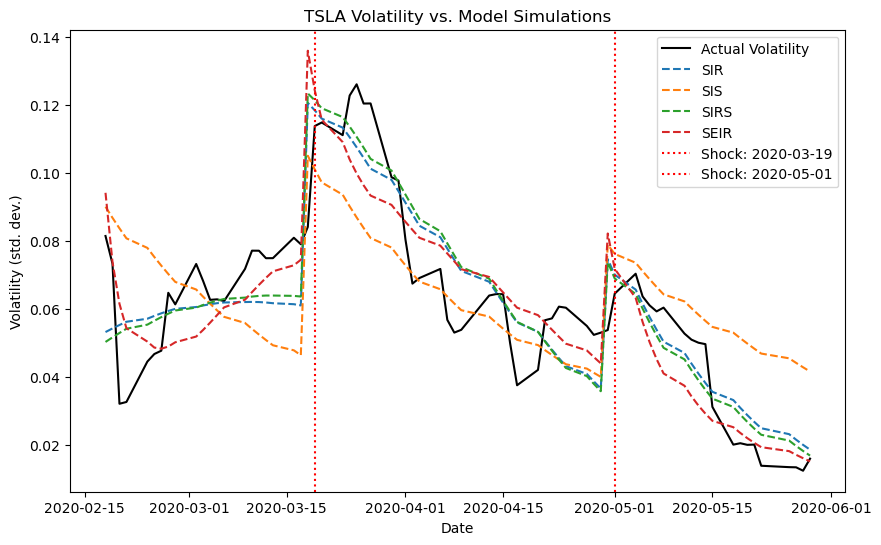

In [ ]:
# Plot Results
models = {
    'SIR': (simulate_sir, sir_params),
    'SIS': (simulate_sis, sis_params),
    'SIRS': (simulate_sirs, sirs_params),
    'SEIR': (simulate_seir, seir_params)
}

plt.figure(figsize=(10,6))
plt.plot(vol.index, actual_vol, 'k-', label='Actual Volatility')

for name, (func, params) in models.items():
    I_sim = func(*params, days, shock_indices, shock_deltas)
    plt.plot(vol.index, I_sim, '--', label=name)

# Traccia tutte le date di shock
for d in shock_dates:
    plt.axvline(d, color='r', linestyle=':', label=f'Shock: {d.date()}')

plt.legend()
plt.title('TSLA Volatility vs. Model Simulations')
plt.ylabel('Volatility (std. dev.)')
plt.xlabel('Date')
plt.show()


### Assesment of how much the model fit the volatility curve

In [ ]:
# Fit Metrics Table
import pandas as pd
from tabulate import tabulate

results = []
for name, (func, params) in models.items():
    I_sim = func(*params, days, shock_indices, shock_deltas)
    rmse = np.sqrt(np.mean((I_sim - actual_vol)**2))
    mae  = np.mean(np.abs(I_sim - actual_vol))
    
    # Estrai i parametri individuali
    if name == 'SIR' or name == 'SIS':
        β, γ, I0 = params
        ξσ = '-'
    elif name == 'SIRS':
        β, γ, ξ, I0 = params
        ξσ = ξ
    elif name == 'SEIR':
        β, σ, γ, I0 = params
        ξσ = σ
    results.append([name, β, γ, ξσ, I0, rmse, mae])

df_res = pd.DataFrame(results, columns=['Model','β','γ','ξ/σ','I0','RMSE','MAE'])
print(tabulate(df_res, headers='keys', tablefmt='github', showindex=False))


| Model   |        β |        γ | ξ/σ                 |        I0 |      RMSE |       MAE |
|---------|----------|----------|---------------------|-----------|-----------|-----------|
| SIR     | 0.162635 | 0.134043 | -                   | 0.0532201 | 0.0132283 | 0.0110638 |
| SIS     | 0.146919 | 0.16978  | -                   | 0.0900493 | 0.0212157 | 0.0173963 |
| SIRS    | 0.174352 | 0.139027 | 0.0                 | 0.0503125 | 0.0132152 | 0.0109739 |
| SEIR    | 0.798378 | 0.215652 | 0.05322033736517319 | 0.0941524 | 0.0141557 | 0.0108866 |


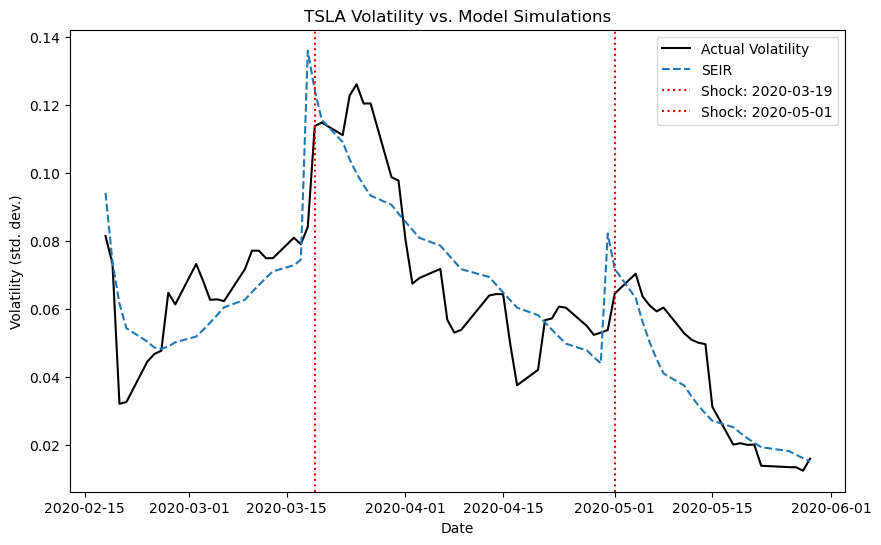

In [ ]:
# SEIR dynamics are plotted
models = {
    'SEIR': (simulate_seir, seir_params)
}

plt.figure(figsize=(10,6))
plt.plot(vol.index, actual_vol, 'k-', label='Actual Volatility')

for name, (func, params) in models.items():
    I_sim = func(*params, days, shock_indices, shock_deltas)
    plt.plot(vol.index, I_sim, '--', label=name)

# shock dates are highlighted
for d in shock_dates:
    plt.axvline(d, color='r', linestyle=':', label=f'Shock: {d.date()}')

plt.legend()
plt.title('TSLA Volatility vs. Model Simulations')
plt.ylabel('Volatility (std. dev.)')
plt.xlabel('Date')
plt.show()

### Correlation of real volatility and simulated one

In [62]:
import numpy as np

# assume `actual_vol` is your array of real volatility
corrs = {}
for name, (func, params) in models.items():
    I_sim = func(*params, days, shock_indices, shock_deltas)
    r = np.corrcoef(I_sim, actual_vol)[0, 1]
    corrs[name] = r

# display
for name, r in corrs.items():
    print(f"{name:4s} correlation = {r:.3f}")


SEIR correlation = 0.860


### Test with network ABM model

We chose not to proceed with this strategy since we couldn't succesfully calibrate the paramters inherently more complex
The homogenous compartment approach we adopted has simplified the market dynamics much more but we thought it would have given a better estimate of the overall market behavior, without considering possible segmentation of the market participants

In [15]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.optimize import minimize

In [16]:
# Load Tesla data and compute normalized volatility series
def load_tesla_volatility(filepath, days=100):
    df = pd.read_csv(filepath)
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df.dropna(subset=['Close'], inplace=True)
    df['log_ret'] = np.log(df['Close']).diff()
    vol_series = df['log_ret'].rolling(window=10).std().dropna()
    vol_series_norm = (vol_series - vol_series.min()) / (vol_series.max() - vol_series.min())
    date_index = df.index[9:9 + days]  # adjust for rolling window offset
    return date_index, vol_series_norm[:days].values

In [17]:

# Create Barabasi–Albert (scale-free) network as it is commonly used in network diffusion studies focused on market dynamics
G_barabasi = nx.barabasi_albert_graph(n=100, m=2)

In [18]:
# General network diffusion simulator
def network_diffusion_sim(G, model, params, I0_frac, days, shock_day=None, shock_delta=0.0):
    node_states = {node: 0 for node in G.nodes}  # 0=S, 1=I, 2=R, 3=E
    num_infected = int(I0_frac * len(G))
    infected_nodes = np.random.choice(list(G.nodes), size=num_infected, replace=False)
    for node in infected_nodes:
        node_states[node] = 1

    infected_counts = []

    for day in range(days):
        new_states = node_states.copy()
        for node in G.nodes:
            state = node_states[node]
            neighbors = list(G.neighbors(node))
            infected_neighbors = sum(1 for n in neighbors if node_states[n] == 1)

            if model == "SIR":
                beta, gamma = params
                if state == 0 and np.random.rand() < 1 - (1 - beta) ** infected_neighbors:
                    new_states[node] = 1
                elif state == 1 and np.random.rand() < gamma:
                    new_states[node] = 2

            elif model == "SIS":
                beta, gamma = params
                if state == 0 and np.random.rand() < 1 - (1 - beta) ** infected_neighbors:
                    new_states[node] = 1
                elif state == 1 and np.random.rand() < gamma:
                    new_states[node] = 0

            elif model == "SIRS":
                beta, gamma, xi = params
                if state == 0 and np.random.rand() < 1 - (1 - beta) ** infected_neighbors:
                    new_states[node] = 1
                elif state == 1 and np.random.rand() < gamma:
                    new_states[node] = 2
                elif state == 2 and np.random.rand() < xi:
                    new_states[node] = 0

            elif model == "SEIR":
                beta, sigma, gamma = params
                if state == 0 and np.random.rand() < 1 - (1 - beta) ** infected_neighbors:
                    new_states[node] = 3
                elif state == 3 and np.random.rand() < sigma:
                    new_states[node] = 1
                elif state == 1 and np.random.rand() < gamma:
                    new_states[node] = 2

        if shock_day is not None and day == shock_day:
            susceptible_nodes = [n for n, s in new_states.items() if s == 0]
            shock_infections = min(int(shock_delta * len(G)), len(susceptible_nodes))
            new_infections = np.random.choice(susceptible_nodes, size=shock_infections, replace=False)
            for node in new_infections:
                new_states[node] = 1

        node_states = new_states
        infected_counts.append(sum(1 for state in node_states.values() if state == 1) / len(G))

    return infected_counts




### Calibration of the models using SSE

In [19]:
# Helper function to compute SSE
def compute_sse(simulated, observed):
    min_len = min(len(simulated), len(observed))
    return np.sum((np.array(simulated[:min_len]) - np.array(observed[:min_len]))**2)

# Optimization for parameter calibration
def optimize_model(model_name, param_bounds, initial_params, G, I0_frac, days, shock_day, shock_delta, target_series):
    def objective(params):
        sim_series = network_diffusion_sim(G, model_name, params, I0_frac, days, shock_day, shock_delta)
        return compute_sse(sim_series, target_series)
    result = minimize(objective, initial_params, bounds=param_bounds, method='L-BFGS-B')
    return result.x, result.fun


### Plot of the simulated data

In [20]:
# Averaging function for smoothing network simulation
def average_simulations(model_name, params, G, I0_frac, days, shock_day, shock_delta, n_runs=30):
    all_runs = np.zeros((n_runs, days))
    for i in range(n_runs):
        sim = network_diffusion_sim(G, model_name, params, I0_frac, days, shock_day, shock_delta)
        all_runs[i] = sim
    return np.mean(all_runs, axis=0)

# Plotting function to compare all models to real data
def plot_all_models(date_index, real_series, model_fits):
    plt.figure(figsize=(12, 6))
    plt.plot(date_index, real_series, label='Real Volatility', color='black', linewidth=2)
    for model_name, series in model_fits.items():
        plt.plot(date_index, series, label=f'{model_name} Avg (30 runs)', linestyle='--')
    plt.title("Model Fits vs Real Volatility")
    plt.xlabel("Date")
    plt.ylabel("Normalized Volatility / Infection Level")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Full workflow to compare the models

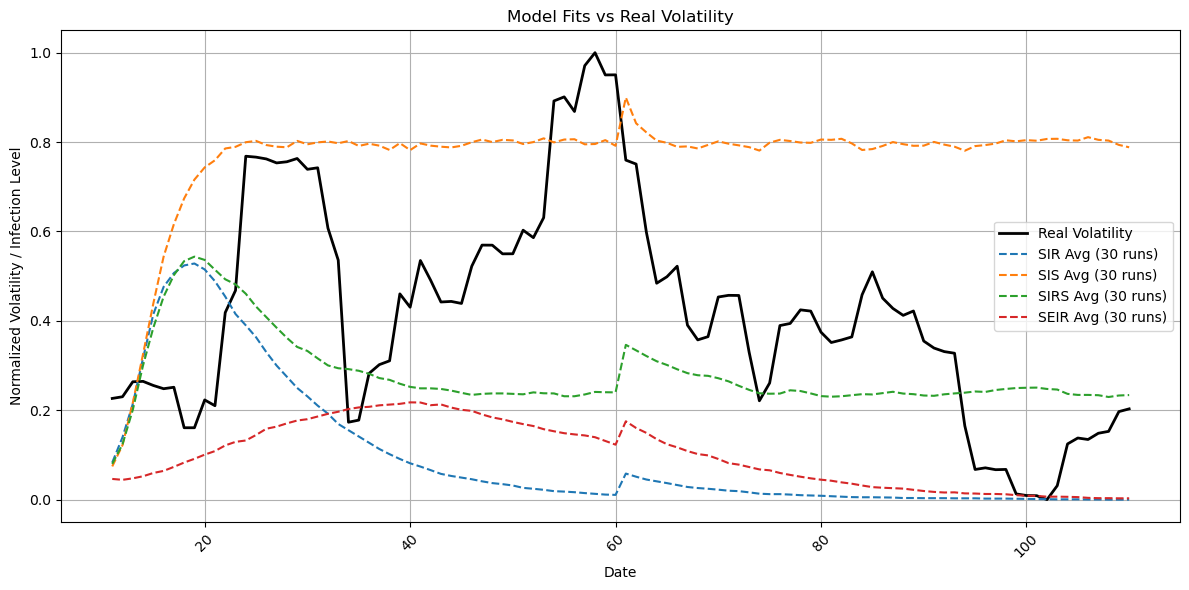

Model: SIR, MSE: 0.1817
Model: SIS, MSE: 0.1816
Model: SIRS, MSE: 0.0826
Model: SEIR, MSE: 0.1443


In [14]:
# Full workflow to load data, calibrate models, and plot results
if __name__ == "__main__":
    filepath = 'tesla_stock_price.csv'  # update this path as needed
    date_index, real_vol = load_tesla_volatility(filepath)

    models = {
        "SIR": ([0.2, 0.1], [(0.01, 1.0), (0.01, 1.0)]),
        "SIS": ([0.2, 0.1], [(0.01, 1.0), (0.01, 1.0)]),
        "SIRS": ([0.2, 0.1, 0.05], [(0.01, 1.0), (0.01, 1.0), (0.001, 0.5)]),
        "SEIR": ([0.2, 0.1, 0.1], [(0.01, 1.0), (0.01, 1.0), (0.01, 1.0)])
    }

    model_fits = {}
    model_mse = {}

    for model, (init, bounds) in models.items():
        best_params, _ = optimize_model(
            model_name=model,
            param_bounds=bounds,
            initial_params=init,
            G=G_barabasi,
            I0_frac=0.05,
            days=100,
            shock_day=50,
            shock_delta=0.1,
            target_series=real_vol
        )
        avg_sim = average_simulations(
            model_name=model,
            params=best_params,
            G=G_barabasi,
            I0_frac=0.05,
            days=100,
            shock_day=50,
            shock_delta=0.1,
            n_runs=30
        )
        model_fits[model] = avg_sim
        model_mse[model] = compute_sse(avg_sim, real_vol) / len(real_vol)

    plot_all_models(date_index, real_vol, model_fits)

    for model, mse in model_mse.items():
        print(f"Model: {model}, MSE: {mse:.4f}")
